In [1]:
import pandas as pd
import os
import numpy as np
import warnings
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split


In [15]:
#-------------------------------------------------------#-------------------------------------------------------#
# The dataframe are created following the output of the LOBSTER data:
#     The variables for the message are (in order): Time: (expressed as second after 00:00); 
#                                   Event type: (1: submission of new l.o.: 2:Cancellation (partial del. of l.o.); 3:Deletion of l.o.; 4:Exec. of visible l.o.; 5: exec. of hidden l.o.; 6: cross trade; 7:trading halt indicator)
#                                   Order ID (0 for hidden order);
#                                   Size
#                                   Price: Dollar price times 10000. E.G. $91.14 -> 911400
#                                   Direction: -1 Sell, +1 Buy
#
#     VERY IMPORTANT: when event type = 7 it means the trades are halted, Price and Direction are setted to -1
#                     all the other to 0. When trading resume event type is 7 but PRICE = 1!!!!  
#-------------------------------------------------------#-------------------------------------------------------#

def dfmessage():
    warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

    data_cube_message = {}
    csv_directory_message = 'C:/Users/gabri/Desktop/Uni/Msc QF/2nd year/AlgoTrading/Paper/Data/Message' #Change with personal path
    for file_name in os.listdir(csv_directory_message):
        if file_name.endswith('.csv'):  # Only process CSV files
            
            day_label = file_name[:16]
            
            file_path = os.path.join(csv_directory_message, file_name)
            df = pd.read_csv(file_path, header=None, skiprows=1)
            df = df.drop(df.columns[-1], axis=1)
            
            df.columns = ["Sec. After MidN", "Event Type", "Order ID", "Size", "Price", "Direction"]
            df["Check"] = range(len(df))
            
            df["Direction"] = df["Direction"] * -1
            df["Signed Size"] = df["Direction"] * df["Size"]
            
            data_cube_message[day_label] = df
            print(f"**********Creating Dataframe for {day_label}**********", "\n")
    print("Dictionary for Trade Book created!!")
            
    return data_cube_message



dictmessage = dfmessage()


#-------------------------------------------------------#-------------------------------------------------------#
# The dataframe are created following the output of the LOBSTER data:
#     The variables for the order are (in order): Best Ask price
#                                                 Best Ask Size
#                                                 Best Bid Price
#                                                 Best Bid Size
#-------------------------------------------------------#-------------------------------------------------------#



def dforder():
    data_cube_orderbook = {}
    csv_directory_order = 'C:/Users/gabri/Desktop/Uni/Msc QF/2nd year/AlgoTrading/Paper/Data/OrderBook' #Change with personal path

    for file_name in os.listdir(csv_directory_order):
        if file_name.endswith('.csv'):  
            
            day_label = file_name[:16]
            
            file_path = os.path.join(csv_directory_order, file_name)
            df = pd.read_csv(file_path, header=None, skiprows=1)
            
            df.columns = ["BestAsk Price", "BestAsk Size", "BestBid Price", "BestBid Size"]
            


          
            data_cube_orderbook[day_label] = df
            print(f"**********Creating Dataframe for {day_label}**********", "\n")
    print("Dictionary for LOB created!!")
    return data_cube_orderbook

dictorder = dforder()

def dfjoiner():
    dictjoined = {}
    for i in dictmessage:
        res = pd.concat([dictmessage[i], dictorder[i]], axis=1)
        resf = res[res["Event Type"].isin([4, 5])]
        dictjoined[i] = resf
    return dictjoined

dictjoined = dfjoiner()


def addvariables():
    dictionary = {}
    for i in dictjoined:
        df = dictjoined[i]
        
        df["MidPrice"] = (df["BestAsk Price"] + df["BestBid Price"])/2
        df["MidPrice_t+1"] = df["MidPrice"].shift(-1)
        df["LN Return"] = np.log(df["MidPrice_t+1"]/df["MidPrice"])
        df["DepthImbalance"] = ((df["BestBid Size"] - df["BestAsk Size"]) / (df["BestBid Size"] + df["BestAsk Size"]))
        df["DI"] = np.where(df["DepthImbalance"] >= 0, '+DI', '-DI')
        df = df[:-1]
        dictionary[i] = df
    return dictionary

dbdata = addvariables()

####______________________________________________________########
# 
#      Calculate the transition prob from one state tuple
#      to another one.  
# 
####______________________________________________________########    


def trans_prob(x):
    df = x  

    df['State'] = list(zip(df['DI'], df['Direction']))
    df['Next_State'] = df['State'].shift(-1)

    df = df[:-1]

    transition_counts = df.groupby(['State', 'Next_State']).size().unstack(fill_value=0)
   
    transition_probs = transition_counts.div(transition_counts.sum(axis=1), axis=0)
    

    print("Transition Probabilities:")
    print(transition_probs)
    return transition_probs





**********Creating Dataframe for MSFT_2020-03-02_********** 

**********Creating Dataframe for MSFT_2020-03-03_********** 

**********Creating Dataframe for MSFT_2020-03-04_********** 

**********Creating Dataframe for MSFT_2020-03-05_********** 

**********Creating Dataframe for MSFT_2020-03-06_********** 

**********Creating Dataframe for MSFT_2020-03-09_********** 

**********Creating Dataframe for MSFT_2020-03-10_********** 

**********Creating Dataframe for MSFT_2020-03-11_********** 

**********Creating Dataframe for MSFT_2020-03-12_********** 

**********Creating Dataframe for MSFT_2020-03-13_********** 

**********Creating Dataframe for MSFT_2020-03-16_********** 

**********Creating Dataframe for MSFT_2020-03-17_********** 

**********Creating Dataframe for MSFT_2020-03-18_********** 

**********Creating Dataframe for MSFT_2020-03-19_********** 

**********Creating Dataframe for MSFT_2020-03-20_********** 

**********Creating Dataframe for MSFT_2020-03-23_********** 

********

In [11]:
value_counts = dbdata["MSFT_2020-03-02_"]['DepthImbalance'].value_counts()
print(value_counts)

DepthImbalance
 0.000000    18483
 0.333333     7271
-0.333333     7001
-0.818182     2998
 0.818182     2879
             ...  
-0.014342        1
 0.013942        1
-0.828840        1
-0.831010        1
-0.288744        1
Name: count, Length: 31007, dtype: int64


In [12]:
dbdata["MSFT_2020-03-02_"][1000:10050]

,Sec. After MidN,Event Type,Order ID,Size,Price,Direction,Check,Signed Size,BestAsk Price,BestAsk Size,BestBid Price,BestBid Size,MidPrice,MidPrice_t+1,LN Return,DepthImbalance,DI
2110,34209.007555,4,32627691,20,1650500,-1,2110,-20,1652200,300,1650500,80,1651350.0,1650950.0,-0.000242,-0.578947,-DI
2115,34209.008130,4,32627691,80,1650500,-1,2115,-80,1651500,10,1650400,3,1650950.0,1650850.0,-0.000061,-0.538462,-DI
2117,34209.008256,4,32649295,20,1650600,1,2117,20,1651300,200,1650400,3,1650850.0,1650800.0,-0.000030,-0.970443,-DI
2121,34209.011329,4,32114939,3,1650400,-1,2121,-3,1651300,100,1650300,100,1650800.0,1650700.0,-0.000061,0.000000,+DI
2122,34209.011329,4,32525759,100,1650300,-1,2122,-100,1651300,100,1650100,144,1650700.0,1650600.0,-0.000061,0.180328,+DI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30797,34589.435432,5,0,100,1642700,-1,30797,-100,1642800,110,1642500,1055,1642650.0,1642850.0,0.000122,0.811159,+DI
30800,34589.444467,4,53412687,100,1642800,1,30800,100,1643200,100,1642500,955,1642850.0,1643000.0,0.000091,0.810427,+DI
30804,34589.452187,4,53413367,100,1642800,-1,30804,-100,1643400,100,1642600,10,1643000.0,1643000.0,0.000000,-0.818182,-DI
30827,34589.473709,5,0,100,1642700,-1,30827,-100,1643400,100,1642600,100,1643000.0,1642950.0,-0.000030,0.000000,+DI


In [13]:
print(t.iloc[2:2])

Empty DataFrame
Columns: [(+DI, -1), (+DI, 1), (-DI, -1), (-DI, 1)]
Index: []


In [18]:
matrix = t.values.tolist() 
print(matrix)

[[0.6727788199782784, 0.10853773784504281, 0.1754235016996488, 0.04325994047703006], [0.19189869516079316, 0.522115483406966, 0.08781978834891606, 0.19816603308332478], [0.25956846138334344, 0.07828191167574107, 0.5570679572494455, 0.10508166969147005], [0.08212088101673472, 0.20208177583529818, 0.17562827074587384, 0.5401690724020933]]


In [12]:
dfpossell = dbdata["MSFT_2020-03-02_"].loc[(dbdata["MSFT_2020-03-02_"]["DepthImbalance"] >= 0) & (dbdata["MSFT_2020-03-02_"]["Direction"] == -1)]
dfnegsell = dbdata["MSFT_2020-03-02_"].loc[(dbdata["MSFT_2020-03-02_"]["DepthImbalance"] < 0) & (dbdata["MSFT_2020-03-02_"]["Direction"] == -1)]
dfposbuy = dbdata["MSFT_2020-03-02_"].loc[(dbdata["MSFT_2020-03-02_"]["DepthImbalance"] >= 0) & (dbdata["MSFT_2020-03-02_"]["Direction"] == 1)]
dfnegbuy = dbdata["MSFT_2020-03-02_"].loc[(dbdata["MSFT_2020-03-02_"]["DepthImbalance"] < 0) & (dbdata["MSFT_2020-03-02_"]["Direction"] == 1)]




,Sec. After MidN,Event Type,Order ID,Size,Price,Direction,Check,Signed Size,BestAsk Price,BestAsk Size,BestBid Price,BestBid Size,MidPrice,MidPrice_t+1,LN Return,DepthImbalance,DI
42,34200.185803,4,31183215,115,1648500,1,42,115,1649000,230,1645000,142,1647000.0,1647350.0,0.000212,-0.236559,-DI
66,34200.616820,4,31222099,22,1649000,1,66,22,1649200,190,1645700,105,1647450.0,1648550.0,0.000667,-0.288136,-DI
72,34200.891908,4,31138859,90,1649200,1,72,90,1649200,100,1647900,52,1648550.0,1648550.0,0.000000,-0.315789,-DI
117,34201.047103,4,31482163,100,1649200,1,117,100,1650000,103,1649000,40,1649500.0,1649500.0,0.000000,-0.440559,-DI
123,34201.048007,4,31493863,10,1649200,1,123,10,1649200,90,1649100,10,1649150.0,1649500.0,0.000212,-0.800000,-DI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175542,57599.999482,4,809841027,1195,1728500,1,1175542,1195,1728500,20214,1728000,9390,1728250.0,1728250.0,0.000000,-0.365626,-DI
1175543,57599.999482,4,810693387,300,1728500,1,1175543,300,1728500,19914,1728000,9390,1728250.0,1728250.0,0.000000,-0.359132,-DI
1175544,57599.999482,4,810693611,500,1728500,1,1175544,500,1728500,19414,1728000,9390,1728250.0,1728250.0,0.000000,-0.348007,-DI
1175545,57599.999482,4,811006883,100,1728500,1,1175545,100,1728500,19314,1728000,9390,1728250.0,1728250.0,0.000000,-0.345736,-DI


In [13]:
m1 = np.mean(dfpossell["LN Return"])*10000
m2 = np.mean(dfnegsell["LN Return"])*10000
m3 = np.mean(dfposbuy["LN Return"])*10000
m4 = np.mean(dfnegbuy["LN Return"])*10000



print(m1)
print("\n")
print(m2)
print("\n")
print(m3)
print("\n")
print(m4)
print("\n")


-0.09819277912361216


-0.2265965189351358


0.32972324927355756


0.16971268691772615




C:\Users\gabri\AppData\Local\Temp\ipykernel_3888\26166951.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['State'] = list(zip(df['DI'], df['Direction']))
C:\Users\gabri\AppData\Local\Temp\ipykernel_3888\26166951.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Next_State'] = df['State'].shift(-1)


Transition Probabilities:
Next_State  (+DI, -1)  (+DI, 1)  (-DI, -1)  (-DI, 1)
State                                               
(+DI, -1)    0.672779  0.108538   0.175424  0.043260
(+DI, 1)     0.191899  0.522115   0.087820  0.198166
(-DI, -1)    0.259568  0.078282   0.557068  0.105082
(-DI, 1)     0.082121  0.202082   0.175628  0.540169


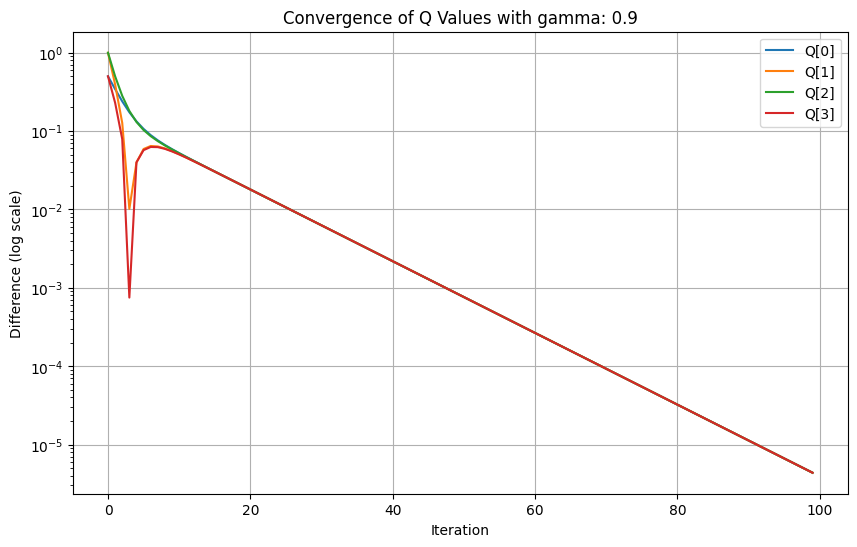

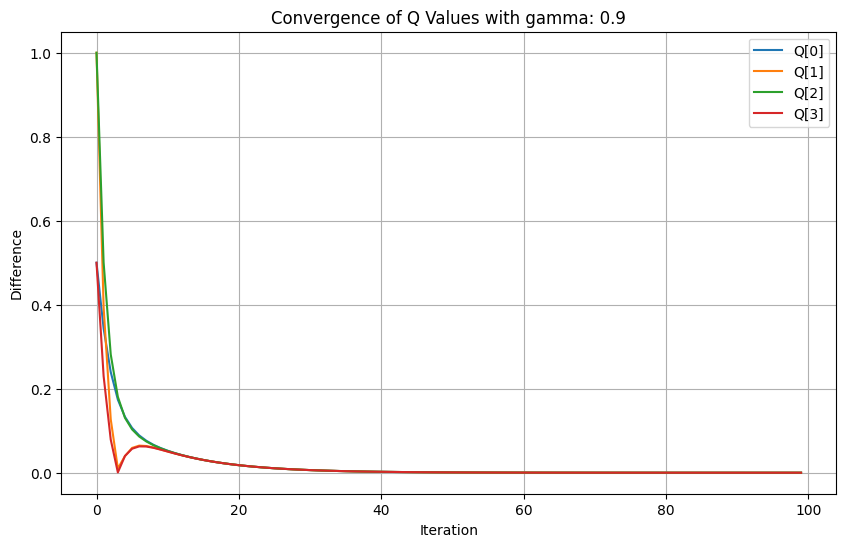

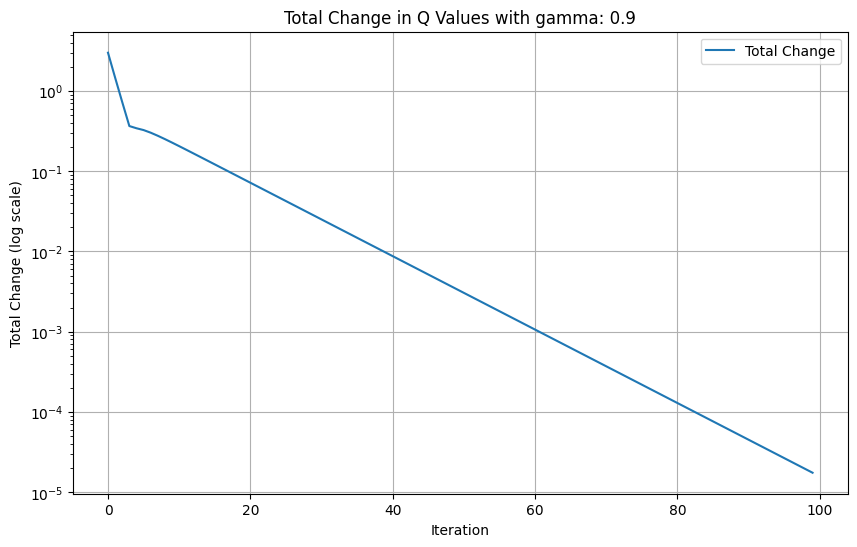

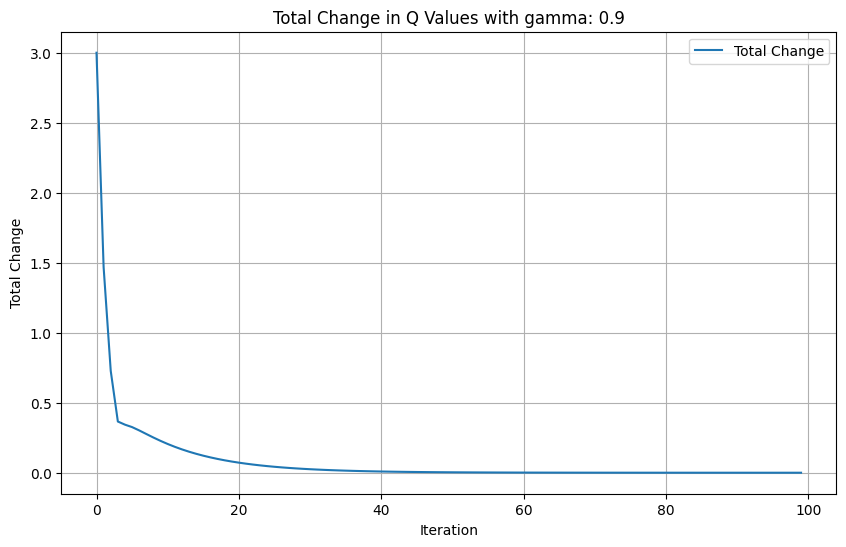

In [16]:
#-------------------------------------------------------#-------------------------------------------------------#
#       Recursion to find the Q, one can find the immediate rewards as the mean of the sliced dataframe
#       calculated above. 
#
#-------------------------------------------------------#-------------------------------------------------------#

g = 0.9
def permanent_price_impact():
    R_negDI_sell = -1
    R_posDI_sell = -0.5
    R_negDI_buy =  0.5
    R_posDI_buy = 1

    R = [R_negDI_sell, R_posDI_sell, R_negDI_buy, R_posDI_buy]

    gamma = g

    T_matrix = trans_prob(dbdata["MSFT_2020-03-02_"])
    T_matrix = T_matrix.values.tolist()

    Q_posDI_sell = 0
    Q_posDI_buy = 0
    Q_negDI_sell = 0
    Q_negDI_buy = 0

    Q = [Q_posDI_sell, Q_posDI_buy, Q_negDI_sell, Q_negDI_buy]
    Q_values = [Q.copy()]  # Store initial Q values

    for i in range(100):
        Q_posDI_sell = R_posDI_sell + gamma * (T_matrix[0][0] * Q[0] +
                                               T_matrix[0][1] * Q[1] +
                                               T_matrix[0][2] * Q[2] +
                                               T_matrix[0][3] * Q[3])

        Q_posDI_buy = R_posDI_buy + gamma * (T_matrix[1][0] * Q[0] +
                                             T_matrix[1][1] * Q[1] +
                                             T_matrix[1][2] * Q[2] +
                                             T_matrix[1][3] * Q[3])

        Q_negDI_sell = R_negDI_sell + gamma * (T_matrix[2][0] * Q[0] +
                                               T_matrix[2][1] * Q[1] +
                                               T_matrix[2][2] * Q[2] +
                                               T_matrix[2][3] * Q[3])

        Q_negDI_buy = R_negDI_buy + gamma * (T_matrix[3][0] * Q[0] +
                                             T_matrix[3][1] * Q[1] +
                                             T_matrix[3][2] * Q[2] +
                                             T_matrix[3][3] * Q[3])
        Q = [Q_posDI_sell, Q_posDI_buy, Q_negDI_sell, Q_negDI_buy]
        Q_values.append(Q.copy())  # Store Q values at each iteration

    return Q_values



# Calculate the differences between consecutive iterations
def calculate_differences(Q_values):
    differences = []
    for i in range(1, len(Q_values)):
        diff = [abs(Q_values[i][j] - Q_values[i-1][j]) for j in range(len(Q_values[i]))]
        
        differences.append(diff)
    
    
    return differences

def plot_convergence(differences):
    plt.figure(figsize=(10, 6))
    for j in range(len(differences[0])):
        plt.plot([diff[j] for diff in differences], label=f'Q[{j}]')
    plt.yscale('log')
    plt.title(f'Convergence of Q Values with gamma: {g}')
    plt.xlabel('Iteration')
    plt.ylabel('Difference (log scale)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for j in range(len(differences[0])):
        plt.plot([diff[j] for diff in differences], label=f'Q[{j}]')
    plt.title(f'Convergence of Q Values with gamma: {g}')
    plt.xlabel('Iteration')
    plt.ylabel('Difference')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the change list
    change = [sum(diff) for diff in differences]
    plt.figure(figsize=(10, 6))
    plt.plot(change, label='Total Change')
    plt.yscale('log')
    plt.title(f'Total Change in Q Values with gamma: {g}')
    plt.xlabel('Iteration')
    plt.ylabel('Total Change (log scale)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(change, label='Total Change')
    plt.title(f'Total Change in Q Values with gamma: {g}')
    plt.xlabel('Iteration')
    plt.ylabel('Total Change')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
Q_values = permanent_price_impact()
differences = calculate_differences(Q_values)
plot_convergence(differences)



C:\Users\gabri\AppData\Local\Temp\ipykernel_4956\1646695647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"DepthImbalance_lag_{lag}"] = data["DepthImbalance"].shift(lag)
C:\Users\gabri\AppData\Local\Temp\ipykernel_4956\1646695647.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgdata.dropna(inplace=True)
C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [21:13:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autos

Accuracy: 0.6340019053013723
              precision    recall  f1-score   support

           0       0.62      0.88      0.73     21584
           1       0.68      0.33      0.45     17255

    accuracy                           0.63     38839
   macro avg       0.65      0.60      0.59     38839
weighted avg       0.65      0.63      0.60     38839



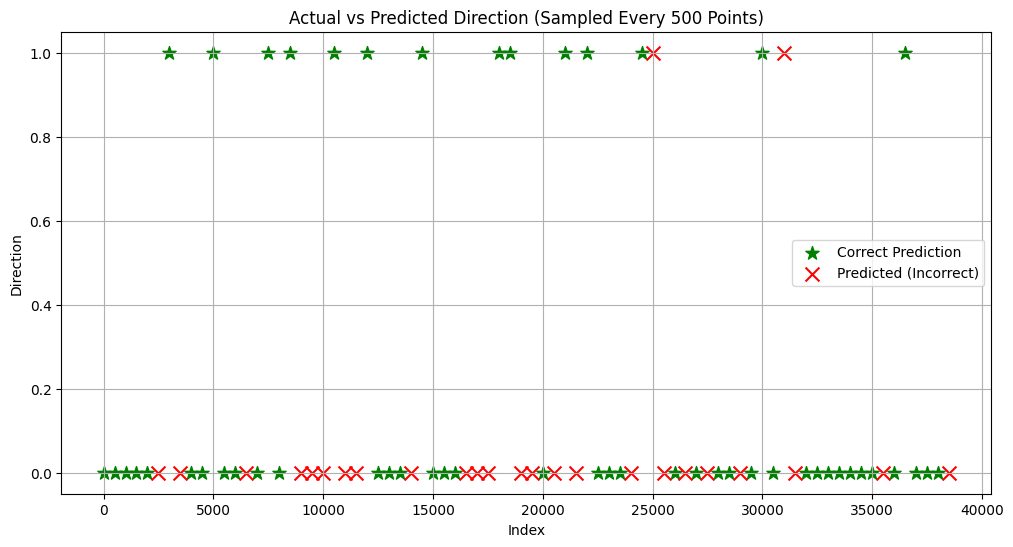

In [5]:



def create_lagged_features(data, lags):
    for lag in lags:
        data[f"DepthImbalance_lag_{lag}"] = data["DepthImbalance"].shift(lag)
    return data

# Define the lags you want to create
lags = [1, 2, 3]  # You can adjust this based on your needs
xgdata = create_lagged_features(dbdata["MSFT_2020-03-02_"], lags)

# Drop rows with NaN values (due to lagging)
xgdata.dropna(inplace=True)

# Define features and target variable
X = xgdata[[f"DepthImbalance_lag_{lag}" for lag in lags]]
y = xgdata["Direction"].map({-1: 0, 1: 1})  # Predicting Direction


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

params = {
    "objective": "binary:logistic",  # Problema di classificazione binaria
    "eval_metric": "logloss",       # Log loss come metrica di valutazione
    "eta": 0.1,                     # Learning rate
    "use_label_encoder": True,
    "max_depth": 6,                 # Profondità massima degli alberi
    "subsample": 0.8,               # Percentuale di dati usata per ogni albero
    "colsample_bytree": 0.8,        # Percentuale di feature usata per ogni albero
    "seed": 42                      # Riproducibilità
}

# Train the XGBoost model
model = XGBClassifier(params=params)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Sample every 100th value of the test set
sample_indices = np.arange(0, len(y_test), 500)
y_test_sampled = y_test.iloc[sample_indices]
y_pred_sampled = y_pred[sample_indices]

# Plotting the predictions and actual values
plt.figure(figsize=(12, 6))

# Points where actual equals predicted (correct predictions)
correct_indices = sample_indices[y_test_sampled == y_pred_sampled]
plt.scatter(correct_indices, y_test_sampled[y_test_sampled == y_pred_sampled], label="Correct Prediction", color="green", marker="*", s=100)

# Points where actual does not equal predicted (incorrect predictions)
incorrect_indices = sample_indices[y_test_sampled != y_pred_sampled]
plt.scatter(incorrect_indices, y_pred_sampled[y_test_sampled != y_pred_sampled], label="Predicted (Incorrect)", color="red", marker="x", s=100)

plt.title("Actual vs Predicted Direction (Sampled Every 500 Points)")
plt.xlabel("Index")
plt.ylabel("Direction")
plt.legend()
plt.grid(True)
plt.show()